**Using the CIFAR10 dataset**

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install fastai torch

In [0]:
!wget http://pjreddie.com/media/files/cifar.tgz

In [0]:
!tar -xzvf cifar.tgz

In [0]:
!rm cifar.tgz

In [0]:
import os
import shutil
def create_dir_structure(dir = 'cifar/train'):
  fnames = [f for f in os.listdir(dir)]
  for fname in fnames:
    if not os.path.isdir(f'{dir}/{fname}'):
      if not os.path.exists(f'{dir}/{fname.split("_")[1].split(".")[0]}'):
        os.mkdir(f'{dir}/{fname.split("_")[1].split(".")[0]}')
      shutil.move(f'{dir}/{fname}', f'{dir}/{fname.split("_")[1].split(".")[0]}/{fname}')

In [0]:
create_dir_structure()
create_dir_structure('cifar/test')

In [0]:
from fastai.vision import *

In [0]:
PATH = 'cifar/'
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = ([ 0.4914 ,  0.48216,  0.44653], [ 0.24703,  0.24349,  0.26159])


In [0]:
from torch.autograd import Variable
stats_tensor1 = stats_tensor.type(torch.cuda.DoubleTensor)
stats_tensor1 = Variable(stats_tensor1.cuda())

In [0]:
def get_data(sz, bs):
  tfms = get_transforms(do_flip = True)
  return ImageDataBunch.from_folder(PATH, valid='test', bs = bs).normalize(stats)

In [0]:
bs = 256

In [0]:
data = get_data(32, 4)

In [15]:
data.train_ds.x[0].data.type()

'torch.FloatTensor'

In [0]:
#from torch import pytorch
torch.set_default_tensor_type('torch.cuda.FloatTensor')
x, y = next(iter(data.train_dl)) 

**SIMPLE CONVOLUTIONAL NEURAL NET FROM SCRATCH**

In [0]:
data = get_data(32, bs)

In [0]:
lr = 1e-2

In [0]:
class SimpleNet(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    #a linear layer is added taken layer[i] inputs and layer[i+1] outputs, and added as an nn.Module using ModuleList
  
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    for l in self.layers:
      l_x = l(x)
      x = F.relu(l_x) #non linear layer is added at forward step
    return F.log_softmax(x, dim = -1)
  

In [0]:
def create_cnn_for_customnet(data:DataBunch, 
                model:nn.Module, 
                bn_final:bool=False,ps:Floats=0.5, **kwargs:Any)->Learner:
    "Build convnet style learners."
   
   
    learn = Learner(data, model, **kwargs)
    apply_init(model, nn.init.kaiming_normal_)
    return learn

#TODO : Come back to modify the split_on parameter in ready-made function call

In [0]:
learner = create_cnn_for_customnet(data, SimpleNet([(32*32*3), 40, 10]))

In [34]:
learner

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (50000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (50000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Valid: LabelList
y: CategoryList (10000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (10000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Test: None, model=SimpleNet(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=10, bias=True)
  )
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=<fastai.layers.FlattenedLoss object at 0x7fcb38ebfb00>, metrics=[], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('

In [35]:
[o.numel() for o in learner.model.parameters()]
#the weights matrices contain input*output number of parameters to train

[122880, 40, 400, 10]

In [50]:
learner.lr_find()

epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


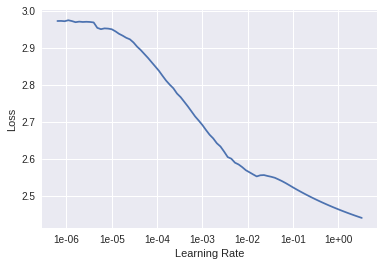

In [51]:
learner.recorder.plot()

In [52]:
lr = 1e-1
%time learner.fit(2, lr)

epoch,train_loss,valid_loss
1,3.703437,2.303305
2,2.329436,2.302585


CPU times: user 4.71 s, sys: 1.35 s, total: 6.06 s
Wall time: 51.1 s


In [53]:
%time learner.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss
1,2.302526,2.302585
2,2.302425,2.302585


CPU times: user 4.73 s, sys: 1.42 s, total: 6.15 s
Wall time: 51.4 s


If we run more number of epochs, losses gradually decrease. TODO: Apply transformations on image data.

**Convolutional Neural Network**

In [0]:
class ConvNet(nn.Module):
  def __init__(self, layers, c):
    super().__init__()
    self.layers = nn.ModuleList([nn.Conv2d(layers[i], layers[i+1], kernel_size = 3, stride = 2)
                                for i in range(len(layers)-1)])
    self.pool = nn.AdaptiveMaxPool2d(1)
    self.out = nn.Linear(layers[-1], c)
    
  def forward(self, x):
    for l in self.layers: x = F.relu(l(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    return F.log_softmax(self.out(x), dim = -1)

In [0]:
conv_learner = create_cnn_for_customnet(data, ConvNet([3, 20, 40, 80], 10))

In [62]:
conv_learner

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (50000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (50000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Valid: LabelList
y: CategoryList (10000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (10000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Test: None, model=ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(2, 2))
    (1): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2))
    (2): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (pool): AdaptiveMaxPool2d(output_size=1)
  (out): Linear(in_features=80, out_features=10, bias=True)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.

In [63]:
conv_learner.lr_find(end_lr = 100)

epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


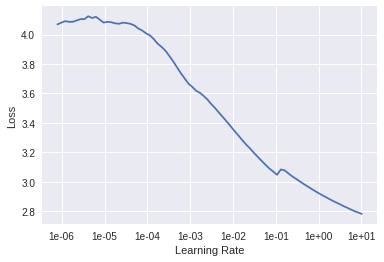

In [64]:
conv_learner.recorder.plot()

In [65]:
lr = 1e-1
conv_learner.fit(2, 1e-1)

epoch,train_loss,valid_loss
1,2.491561,2.305793
2,2.310532,2.305368


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8b9237ed68>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8b9237ed68>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", 

In [66]:
conv_learner.fit_one_cycle(4, 1e-1)

epoch,train_loss,valid_loss
1,2.306291,2.309198
2,2.306152,2.308832
3,2.304577,2.303463
4,2.302945,2.302645


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8b9237ed68>>
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8b9237ed68>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
    w.join()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    

**Refactored CNN with Convolution Layer as a separate module**

In [0]:
class Conv2dLayer(nn.Module):
  def __init__(self, ni, nf, kernel_size = 3, stride = 2):
    super().__init__()
    self.layer = nn.Conv2d(ni, nf, kernel_size, stride, padding = 1)
    
  def forward(self, x):
    return F.relu(self.layer(x))

In [0]:
class ConvLearner(nn.Module):
  def __init__(self, layers, c):
    super().__init__()
    self.layers = nn.ModuleList([Conv2dLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    self.out = nn.Linear(layers[-1], c)
    
  def forward(self, x):
    for l in self.layers:
      x = l(x)
      x = F.adaptiveMaxPooling2d(x, 1)
      x = x.view(x.size(0), -1)
      return F.log_softmax(self.out(x), dim = -1)

In [0]:
conv_learner_refactored = create_cnn_for_customnet(data, ConvNet([3, 20, 40, 80], 10))

In [72]:
conv_learner_refactored

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (50000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (50000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Valid: LabelList
y: CategoryList (10000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (10000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Test: None, model=ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(2, 2))
    (1): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2))
    (2): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (pool): AdaptiveMaxPool2d(output_size=1)
  (out): Linear(in_features=80, out_features=10, bias=True)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.

In [73]:
%time conv_learner_refactored.lr_find()

epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 1.68 s, sys: 446 ms, total: 2.12 s
Wall time: 11.6 s


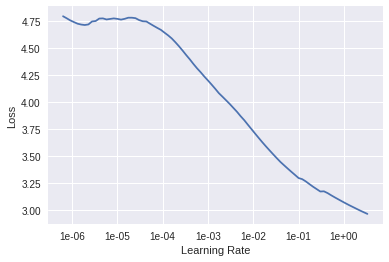

In [74]:
conv_learner_refactored.recorder.plot()

In [75]:
conv_learner_refactored.fit(2, lr)

epoch,train_loss,valid_loss
1,2.578134,2.308977
2,2.313254,2.304395


In [76]:
conv_learner_refactored.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss
1,2.306384,2.312446
2,2.303703,2.303062


**Batch Norm**

In [0]:
class BnLayer(nn.Module):
  def __init__(self, ni, nf, stride = 2, kernel_size = 3):
    super().__init__()
    self.conv = nn.Conv2d(ni, nf, kernel_size = kernel_size,  stride = stride, bias = False, padding = 1) 
    self.a = nn.Parameter(torch.zeros(nf, 1, 1))
    self.m = nn.Parameter(torch.ones(nf, 1, 1))
    
  def forward(self, x):
    x = F.relu(self.conv(x))
    x_chan = x.transpose(0, 1).contiguous().view(x.size(1), -1)
    if self.training:
      self.means = x_chan.mean(1)[:, None, None]
      self.std = x_chan.std(1)[:, None, None]
    return (x - self.means)/self.std * self.m + self.a

In [0]:
class ConvBnNet(nn.Module):
  def __init__(self, layers, c):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size = 5, stride = 1, padding = 2)
    self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    self.out = nn.Linear(layers[-1], c)
    
  def forward(self, x):
    x = self.conv1(x)
    for l in self.layers: x = l(x)
    x = F.adaptive_max_pool2d(x, 1)
    x = x.view(x.size(0), -1)
    return F.log_softmax(self.out(x), dim = -1)
      

In [0]:
conv_learner_bn =  create_cnn_for_customnet(data, ConvBnNet([10, 20, 40, 80, 160], 10))

In [81]:
conv_learner_bn

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (50000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (50000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Valid: LabelList
y: CategoryList (10000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (10000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Test: None, model=ConvBnNet(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layers): ModuleList(
    (0): BnLayer(
      (conv): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): BnLayer(
      (conv): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (2): BnLayer(
      (conv): Conv2d(40, 80

In [82]:
conv_learner_bn.lr_find()

epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


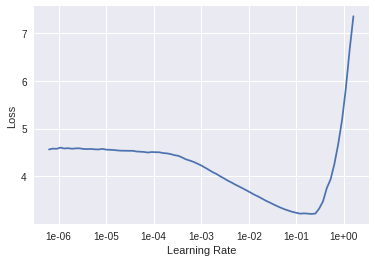

In [83]:
conv_learner_bn.recorder.plot()

In [84]:
lr = 1e-1
conv_learner_bn.fit(2, lr)

epoch,train_loss,valid_loss
1,2.300978,2.572428
2,2.154464,1.974223


In [87]:
conv_learner_bn.fit_one_cycle(4, 0.01)
#This overfits !!

epoch,train_loss,valid_loss
1,nan,nan


KeyboardInterrupt: ignored

**Deep Batch Norm**

In [0]:
class Layer2BatchNorm(nn.Module):
  def __init__(self, layers, c):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size = 5, stride = 1, padding = 2)
    self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers)-1)]) 
    #giving stride 1 to maintain same number of inputs and outputs in second bn layer
    self.out = nn.Linear(layers[-1], c)
  
  def forward(self, x):
    x = self.conv1(x)
    for l, l2 in zip(self.layers, self.layers2):
      x = l(x)
      x = l2(x)
    x = F.adaptive_max_pool2d(x, 1)
    x = x.view(x.size(0), -1)
    return F.log_softmax(self.out(x), dim = -1)

In [0]:
cnn_layer2bn = create_cnn_for_customnet(data, Layer2BatchNorm([10, 20, 40, 80], 10))

In [53]:
cnn_layer2bn

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (50000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (50000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Valid: LabelList
y: CategoryList (10000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (10000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Test: None, model=Layer2BatchNorm(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layers): ModuleList(
    (0): BnLayer(
      (conv): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): BnLayer(
      (conv): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (2): BnLayer(
      (conv): Conv2d(

In [54]:
cnn_layer2bn.lr_find()

epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


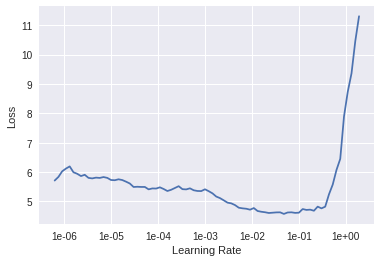

In [55]:
cnn_layer2bn.recorder.plot()

In [58]:
%time cnn_layer2bn.fit_one_cycle(2, 1e-6)

epoch,train_loss,valid_loss
1,3.518460,4.216345
2,3.181979,4.016781


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f12602e7828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f12602e7828>>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    w.join()
As

CPU times: user 8min 24s, sys: 1min 47s, total: 10min 12s
Wall time: 10min 49s


In [59]:
%time cnn_layer2bn.fit_one_cycle(1, 5e-3) #this emerges winner , since fit does not use cosine annealing and does not vary learning rate using SGDR

epoch,train_loss,valid_loss
1,1.476635,2.010776


CPU times: user 4min 13s, sys: 53.9 s, total: 5min 7s
Wall time: 5min 26s


**Resnet : Works on the residuals by batch normalizing them in the second and third levels of layers**

In [0]:
class ResnetLayer(BnLayer):
  def forward(self, x): return x + super().forward(x)

In [0]:
class Resnet(nn.Module):
  def __init__(self, layers, c):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size = 5, stride = 1, padding = 2)
    self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers)-1)])
    self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers)-1)])
    self.out = nn.Linear(layers[-1], c)
    
  def forward(self, x):
    x = self.conv1(x)
    for l, l2, l3 in zip(self.layers, self.layers2, self.layers3):
      x = l3(l2(l(x)))
    x = F.adaptive_max_pool2d(x, 1)
    x = x.view(x.size(0), -1)
    return F.log_softmax(self.out(x), dim = -1)
    

In [0]:
resnet = create_cnn_for_customnet(data, Resnet([10, 20, 40, 80], 10))

In [40]:
resnet

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (50000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (50000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Valid: LabelList
y: CategoryList (10000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (10000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Test: None, model=Resnet(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layers): ModuleList(
    (0): BnLayer(
      (conv): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): BnLayer(
      (conv): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (2): BnLayer(
      (conv): Conv2d(40, 80, k

In [48]:
resnet.lr_find()

epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


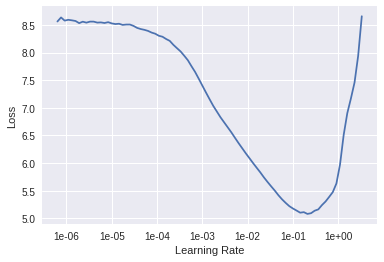

In [50]:
resnet.recorder.plot()

In [52]:
resnet.fit_one_cycle(2, 1e-1) #best performance till now

epoch,train_loss,valid_loss
1,2.711872,2.543808
2,1.530949,1.444626


In [53]:
resnet.fit_one_cycle(2, 1e-1, wd = 1e-5)

epoch,train_loss,valid_loss
1,2.124817,2.174931
2,1.347781,1.275089


**Resnet 2 : Making the first layer batch normalized, adding dropout to better generalize **

In [0]:
class Resnet2(nn.Module):
  def __init__(self, layers, c, p = 0.5):
    super().__init__()
    self.conv1 = BnLayer(3, 16, kernel_size = (7,7), stride = 1)
    self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers)-1)])
    self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers)-1)])
    self.out = nn.Linear(layers[-1], c)
    self.drop = nn.Dropout(p)
    
  def forward(self, x):
    x = self.conv1(x)
    for l, l2, l3 in zip(self.layers, self.layers2, self.layers3):
      x = l3(l2(l(x)))
    x = F.adaptive_max_pool2d(x, 1)
    x = x.view(x.size(0), -1)
    x = self.drop(x)
    return F.log_softmax(self.out(x), dim = -1)

In [0]:
resnet2 = create_cnn_for_customnet(data, Resnet2([16, 32, 64, 128], 10), metrics = accuracy)

In [99]:
resnet2

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (50000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (50000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Valid: LabelList
y: CategoryList (10000 items)
[Category deer, Category deer, Category deer, Category deer, Category deer]...
Path: cifar
x: ImageItemList (10000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: cifar;

Test: None, model=Resnet2(
  (conv1): BnLayer(
    (conv): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (layers): ModuleList(
    (0): BnLayer(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): BnLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (2): B

In [100]:
resnet2.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


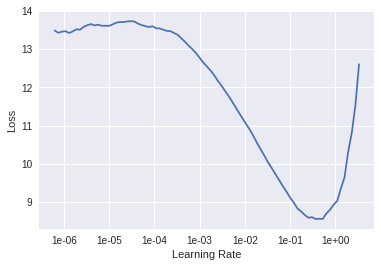

In [101]:
resnet2.recorder.plot()

In [105]:
resnet2.fit_one_cycle(8, 1e-1, wd = 1e-6) #overfitting reduces with number of epochs ?

epoch,train_loss,valid_loss,accuracy
1,2.285906,1.911034,0.340500
2,2.823512,2.402859,0.299600
3,3.116625,2.586019,0.259500
4,2.933853,1.940392,0.349500
5,2.435740,2.326748,0.336400
6,1.981976,1.640708,0.438000
7,1.711808,1.445756,0.496200
8,1.510955,1.384805,0.510200


In [0]:
resnet2.save('final_model')

In [0]:
log_preds, y = resnet2.get_preds() #Could not do .TTA since train ds tfms gives error. TODO: Add tfms flip

In [0]:

y_test = np.argmax(log_preds, 1)

In [109]:
from sklearn.metrics import accuracy_score, log_loss
#print("Log loss: "+str(log_loss(y, y_test)))  #giving different number of categories error
print("Accuracy: "+str(accuracy_score(y_test, y)))

Accuracy: 0.5102
